In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm

VAL_SIZE = 1024

cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=T.ToTensor())
cifar_gpu = dload.cifar_to_gpu(cifar10)
loader_gpu = dload.get_loader_gpu(cifar_gpu, val_size=VAL_SIZE, batch_size=1024)

encoder = Encoder()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [3]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=6, lin_num=3)
model_tmpl = model_gen.generate_model_tmpl()
print(model_tmpl)
fixed_model_gpu = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)

print(encoder.model2vec(model_tmpl), end='\n\n')

print(encoder.model2hash(model_tmpl))

Conv2d       (192, 8, 8)    (3, 3)   (4, 4)  
LeakyReLU    (192, 8, 8)    (0.001) 
Conv2d       (8, 2, 2)      (4, 4)   (3, 3)  
LeakyReLU    (8, 2, 2)      (0.001) 
BatchNorm2d  (8, 2, 2)     
AvgPool2d    (8, 3, 3)      (4, 4)   (1, 1)  
Conv2d       (32, 1, 1)     (1, 1)   (3, 3)  
LeakyReLU    (32, 1, 1)     (0.001) 
MaxPool2d    (32, 1, 1)     (3, 3)   (1, 1)  
BatchNorm2d  (32, 1, 1)    
AvgPool2d    (32, 1, 1)     (2, 2)   (2, 2)  
Conv2d       (32, 1, 1)     (5, 5)   (2, 2)  
LeakyReLU    (32, 1, 1)     (0.001) 
Flatten      32            
Linear       32            
PReLU        32            
Linear       10            

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 

In [4]:
model_tmpl = model_gen.generate_model_tmpl()
arr = encoder.model2vec(model_tmpl)

hex_str = encoder.model2hash(model_tmpl)

print(arr)
print()
print(hex_str)

[[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

0084010520000000004860004000000000293000200000000045200001000000


In [5]:
# df = pd.DataFrame(columns=['hash', 'flops', 'time', 'val_acc', 'train_acc'])
# 
# for i in tqdm(range(10)):
#     model_tmpl = model_gen.generate_model_tmpl()
#     model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
#     flops = calc_model_flops(model, (3, 32, 32))
#     # express train
#     t, val_acc, train_acc = train_express_gpu(model = model,
#                                               train = True,
#                                               loader = loader_gpu,
#                                               milestones = [],
#                                               num_epoch = 1,
#                                               verbose = False)
#     
#     hash_str = encoder.model2hash(model_tmpl)
#     
#     df.loc[i] = [hash_str, flops, t, val_acc, train_acc]
#     
#     with sqlite3.connect('../data/models.db') as conn:
#         df.loc[i:i].to_sql('test', conn, if_exists='append', index=False)
#     
#     # print(df.loc[i])

In [6]:
import sqlite3
import pandas as pd

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)

df.sort_values(by='val_acc', ascending=False, inplace=True)
df

,hex_str,flops,macs,params,time,val_acc,train_acc
930,0080842220000000400000000080412108040000400000...,961733248,480408512,2003755,613.818239,0.813477,0.994141
302,0082082140000000200000000080209210040000008088...,275556800,137555328,824188,258.427490,0.787109,0.976562
23,0082082100491000080800000022c80000802052004920...,48945472,24390976,1144731,177.061507,0.755859,0.996094
763,0080482110080000004910004000000000295000008022...,212892960,106029648,561683,282.491944,0.752930,0.877930
310,0082009110080000002928000100000080004000100200...,12470656,6225408,5552554,13.457602,0.726562,0.918945
...,...,...,...,...,...,...,...
208,0084020508080000008050061004000000821009004260...,21729184,10858496,10761994,164.906045,0.195312,0.284180
129,0080500608040000400000000028b00000449000001000...,448672,200704,181035,16.418530,0.192383,0.167969
115,0082011210080000400000000023480000880061200000...,4776752,2363776,92251,29.879237,0.176758,0.184570
408,0088010520000000400000000028c80000802805200000...,403224,199384,172922,15.385370,0.169922,0.196289


In [7]:
from sophius.encode import Encoder, str_to_vec
from sophius.templates import ModelTmpl_, LinearTmpl, Conv2dTmpl

encoder = Encoder()

In [8]:
def decode_hash(hash_str: str):
    templates = []
    arr = str_to_vec(hash_str)    
    for vec in arr:
        t = encoder.decode_template(vec)
        # print(t.params)
        templates.append(t)
    templates.append(LinearTmpl())
    model = ModelTmpl_((3, 32, 32), 10, *templates)
    return model

def decode_to_templates(hash_str: str):
    templates = []
    arr = str_to_vec(hash_str)    
    for vec in arr:
        t = encoder.decode_template(vec)
        # print(t.params)
        templates.append(t)
    return templates    
            

# df['hex_str'][:1].apply(decode_hash)

In [9]:
df['model'] = df['hex_str'].apply(decode_hash)
df['templates'] = df['hex_str'].apply(decode_to_templates)

In [10]:
df[['model', 'val_acc', 'flops', 'params']]

,model,val_acc,flops,params
930,"Conv2d (96, 32, 32) (3, 3) (1, 1) \...",0.813477,961733248,2003755
302,"Conv2d (32, 31, 31) (2, 2) (1, 1) \...",0.787109,275556800,824188
23,"Conv2d (32, 31, 31) (2, 2) (1, 1) \...",0.755859,48945472,1144731
763,"Conv2d (128, 31, 31) (2, 2) (1, 1) \...",0.752930,212892960,561683
310,"Conv2d (32, 14, 14) (6, 6) (2, 2) \...",0.726562,12470656,5552554
...,...,...,...,...
208,"Conv2d (16, 8, 8) (4, 4) (4, 4) \...",0.195312,21729184,10761994
129,"Conv2d (128, 8, 8) (1, 1) (4, 4) \...",0.192383,448672,181035
115,"Conv2d (32, 16, 16) (5, 5) (2, 2) \...",0.176758,4776752,92251
408,"Conv2d (8, 7, 7) (5, 5) (4, 4) \...",0.169922,403224,172922


In [11]:
for i, row in df[:10].iterrows():
    val_acc = f"val acc: {row['val_acc']:.3f}" 
    flops = f"flops: {row['flops'] // 1024 // 1024}M"
    params = f"params: {row['params'] // 1024 }K"
    print(i, val_acc, flops, params)
    print(row['model'])
    print("="*80)

930 val acc: 0.813 flops: 917M params: 1956K
Conv2d       (96, 32, 32)   (3, 3)   (1, 1)  
ReLU         (96, 32, 32)  
BatchNorm2d  (96, 32, 32)  
Conv2d       (128, 28, 28)  (5, 5)   (1, 1)  
PReLU        (128, 28, 28) 
BatchNorm2d  (128, 28, 28) 
Conv2d       (192, 14, 14)  (7, 7)   (2, 2)  
LeakyReLU    (192, 14, 14)  (0.01)  
AvgPool2d    (192, 14, 14)  (3, 3)   (1, 1)  
Conv2d       (64, 5, 5)     (1, 1)   (3, 3)  
BatchNorm2d  (64, 5, 5)    
AvgPool2d    (64, 3, 3)     (3, 3)   (2, 2)  
PReLU        (64, 3, 3)    
Conv2d       (128, 2, 2)    (2, 2)   (2, 2)  
LeakyReLU    (128, 2, 2)    (0.1)   
AvgPool2d    (128, 2, 2)    (2, 2)   (2, 2)  
Conv2d       (96, 1, 1)     (6, 6)   (4, 4)  
GlobalAvgPool2d (96, 1, 1)    
Flatten      96            
Linear       10            

302 val acc: 0.787 flops: 262M params: 804K
Conv2d       (32, 31, 31)   (2, 2)   (1, 1)  
BatchNorm2d  (32, 31, 31)  
ReLU         (32, 31, 31)  
Conv2d       (192, 16, 16)  (6, 6)   (2, 2)  
LeakyReLU    (192, 

# Plot best results

In [13]:
df[df['params'] < 10000]

,hex_str,flops,macs,params,time,val_acc,train_acc,model,templates
890,008082210044600008040000008400a210080000002530...,21327104,10573184,60971,45.490575,0.689453,0.687500,"Conv2d (96, 29, 29) (4, 4) (1, 1) \...","[Conv2d None (4, 4) (1, 1) ..."
517,0081102240000000004910001002000000840092004450...,19870960,9766144,71754,89.360929,0.684570,0.792969,"Conv2d (64, 32, 32) (1, 1) (1, 1) \...","[Conv2d None (1, 1) (1, 1) ..."
647,008401120042a000200000004000000000808421002550...,2089424,1031616,62218,12.003363,0.673828,0.762695,"Conv2d (16, 16, 16) (5, 5) (2, 2) \...","[Conv2d None (5, 5) (2, 2) ..."
877,0080204a100200000082042210080000400000000028c8...,20301856,10117440,95338,24.135697,0.670898,0.823242,"Conv2d (192, 11, 11) (7, 7) (3, 3) \...","[Conv2d None (7, 7) (3, 3) ..."
371,008202211002000000820422400000000042a000200000...,18489024,9153984,24427,40.766261,0.663086,0.728516,"Conv2d (32, 29, 29) (4, 4) (1, 1) \...","[Conv2d None (4, 4) (1, 1) ..."
...,...,...,...,...,...,...,...,...,...
52,00804412100800000024a8000048600000881005010000...,1915336,905216,24403,17.826802,0.243164,0.247070,"Conv2d (128, 16, 16) (3, 3) (2, 2) \...","[Conv2d None (3, 3) (2, 2) ..."
274,008810060022a800200000004000000020000000001000...,4616,1616,138,9.246439,0.243164,0.238281,"Conv2d (8, 8, 8) (1, 1) (4, 4) \...","[Conv2d None (1, 1) (4, 4) ..."
462,00881006100400000028c8000081100620000000008210...,296608,146176,45260,21.441042,0.222656,0.213867,"Conv2d (8, 8, 8) (1, 1) (4, 4) \...","[Conv2d None (1, 1) (4, 4) ..."
451,008040860044a000002948004000000010080000008090...,2612672,1285632,82955,17.752853,0.201172,0.216797,"Conv2d (128, 9, 9) (6, 6) (4, 4) \...","[Conv2d None (6, 6) (4, 4) ..."


In [14]:
tmpl = df.model.loc[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)
tmpl

Conv2d       (16, 32, 32)   (3, 3)   (1, 1)  
LeakyReLU    (16, 32, 32)   (0.01)  
MaxPool2d    (16, 33, 33)   (2, 2)   (1, 1)  
AvgPool2d    (16, 17, 17)   (4, 4)   (2, 2)  
Conv2d       (16, 9, 9)     (3, 3)   (2, 2)  
PReLU        (16, 9, 9)    
AvgPool2d    (16, 5, 5)     (4, 4)   (2, 2)  
BatchNorm2d  (16, 5, 5)    
Conv2d       (16, 2, 2)     (2, 2)   (4, 4)  
BatchNorm2d  (16, 2, 2)    
ReLU         (16, 2, 2)    
GlobalAvgPool2d (16, 1, 1)    
Flatten      16            
Linear       10            

In [ ]:
from sophius.train import train_on_gpu, train_express_gpu

tmpl = df.model[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                          loader = loader_gpu,
                          milestones = [],
                          num_epoch = 150,
                          verbose = True)

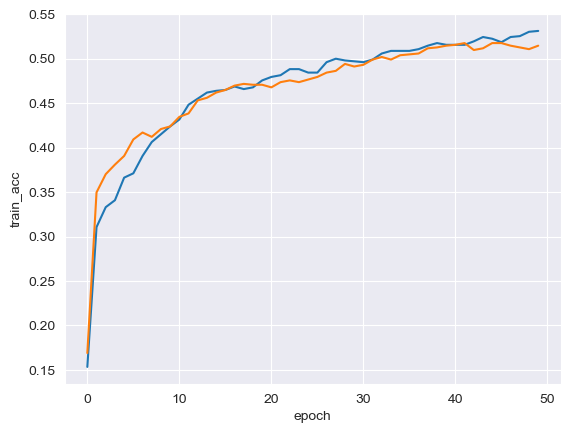

In [16]:
sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');